# Baseline model
Model pour s'habituer au dataset

In [211]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# pip install scikit-plot
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

On importe les dataset

In [212]:
data_application_test = pd.read_csv('../data/application_test.csv')
data_application_train = pd.read_csv('../data/application_train.csv')
# data_bureau_balance = pd.read_csv('../data/bureau_balance.csv')
# data_credit_card_balance  = pd.read_csv('../data/credit_card_balance.csv')
# data_bureau = pd.read_csv('../data/bureau.csv')
# data_HomeCredit_columns_description = pd.read_csv('../data/HomeCredit_columns_description.csv')
# data_installments_payments = pd.read_csv('../data/installments_payments.csv')
# data_POS_CASH_balance = pd.read_csv('../data/POS_CASH_balance.csv')
# data_previous_application = pd.read_csv('../data/previous_application.csv')
data_sample_submission = pd.read_csv('../data/sample_submission.csv')

On nettoie le nom des colonnes car, c'est pénible de manipuler les noms avec des majuscules

In [213]:
data_application_train.columns = [str.lower(x) for x in data_application_train.columns]
data_application_test.columns = [str.lower(x) for x in data_application_test.columns]

In [214]:
data_application_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


On essaye d'avoir le max de features au début, un trie sera nécéssair par la suite. 250 features environ sans compter les autres dataset !

## Data cleaning

Très simple on transforme toutes les variables qualitatives en variables booléenne.

In [215]:
app_train = pd.get_dummies(data_application_train)

In [216]:
app_train = app_train.dropna()

## Modèle

Regression logistique pour commencer.  
Les prochain modèles à tester seront :
- Xgboost
- LightGBM

In [242]:
target = app_train.target
#On drop l'ID mais je n'ai pas vérifier s'il influe sur le résultat
app_train.drop(['sk_id_curr','target'],axis=1,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'target'

Split du dataset d'entrainement. Quand on tu

In [218]:
X_train, X_test, y_train, y_test = train_test_split(app_train, target, test_size=0.4, random_state=1)

In [219]:
regleg = LogisticRegression()
pred = regleg.fit(X_train,y_train).predict_proba(X_test)

0.5869908574814325


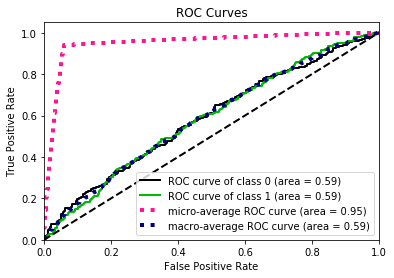

In [240]:
skplt.metrics.plot_roc(y_test, pred)
print(roc_auc_score(y_test, pred[:,1]))

## Submission  
Il manque des occurence pour le dataset test. On rajoute donc les colonnes du dataset d'entrainement dans celui du test.

In [223]:
test = pd.get_dummies(data_application_test) 
app_train.columns.difference(test.columns)

Index(['code_gender_XNA', 'name_family_status_Unknown',
       'name_income_type_Maternity leave'],
      dtype='object')

In [225]:
a = np.setdiff1d(app_train.columns, test.columns)

['code_gender_XNA' 'name_family_status_Unknown'
 'name_income_type_Maternity leave']


In [226]:
test['code_gender_XNA'] = 0
test['name_family_status_Unknown'] = 0
test['name_income_type_Maternity leave'] = 0

In [227]:
test.fillna(0,inplace=True)
test.drop('sk_id_curr',axis=1,inplace=True)

In [234]:
prediction = regleg.predict_proba(test)

In [235]:
data_sample_submission['TARGET'] = prediction[:,1]

In [238]:
data_sample_submission.to_csv('baseline.csv',index=False)